In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from models.MLP import MLP

In [32]:
hidden_dim = 24
layers = 3
output_dim = 1
learning_rate = 0.00005
num_epochs = 4000
epochs_step = 10
batch_size = 32
test_size=0.3
dropout_rate = 0.5
pos_weight_ratio = 10
# ds_name = 'datasets/20220328-or-eng-shrink-full.csv'
ds_name = 'pre_processing/output2.csv'
train = True

In [33]:
data = pd.read_csv(ds_name)

# removed_cols = ['Postoperative Olanzapine', 'Postoperative Fluphenazine', 'Postoperative Flupentixol']
# data = data.drop(removed_cols, axis=1)

# 将特征和目标分开
features = data.drop('Label', axis=1).values
target = data['Label'].values

print(features.shape)
print(target.shape)

(1809, 34)
(1809,)


In [34]:
# 划分训练集和测试集
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=test_size, random_state=42)

In [35]:
# 将数据转换为PyTorch张量
train_features = torch.Tensor(train_features)
test_features = torch.Tensor(test_features)
train_target = torch.tensor(train_target, dtype=torch.float32).view(-1, 1)
test_target = torch.tensor(test_target, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(train_features, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

input_dim = train_features.shape[1]

In [36]:
# Random seed
torch.manual_seed(42)

model = MLP(input_dim, hidden_dim, output_dim,
            layers=layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pos_weight = torch.tensor(
    (train_target == 0).sum() / (train_target == 1).sum(), dtype=torch.float32)
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight*pos_weight_ratio)
unratio_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# To device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
torch.set_float32_matmul_precision('high')

model = model.to(device)
criterion = criterion.to(device)
unratio_criterion = unratio_criterion.to(device)

train_features = train_features.to(device)
test_features = test_features.to(device)
train_target = train_target.to(device)
test_target = test_target.to(device)

# Compile model
model = torch.compile(model)

/tmp/ipykernel_1782/2821676749.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(


tensor(24.3200)


In [37]:
def train_model(model, criterion, optimizer, num_epochs=100):
    train_losses = []
    test_losses = []
    sensitivities = []
    sppecificities = []
    best_model = None
    best_test_loss = 1000
    for epoch in tqdm(range(num_epochs)):
        model.train()

        if epoch == num_epochs // 2:
            criterion = nn.BCEWithLogitsLoss(
                pos_weight=pos_weight*pos_weight_ratio)
            criterion = criterion.to(device)

        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # To device
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # save model
        if (epoch + 1) % epochs_step == 0:
            # test
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            model.eval()
            outputs = model(test_features)
            test_loss = unratio_criterion(outputs, test_target)
            test_losses.append(test_loss.item())

            outputs = outputs > 0.5

            sensitivity = torch.sum(outputs[test_target == 1] == 1).item(
            ) / torch.sum(test_target == 1).item()
            sensitivities.append(sensitivity)

            sppecificity = torch.sum(outputs[test_target == 0] == 0).item(
            ) / torch.sum(test_target == 0).item()
            sppecificities.append(sppecificity)

            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = model

            # torch.save(model.state_dict(),
            #            'pths/MLP-epoch-{}-acc-{:.4f}-sens-{:.4f}.pth'.format(epoch+1, acc*100, sensitivity*100))
    
            if (epoch + 1) % (epochs_step*10)== 0:
                print('Epoch [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}, Sensitivity: {:.4f}, Specificity: {:.4f}'
                    .format(epoch + 1, num_epochs, train_loss, test_loss.item(), sensitivity, sppecificity))
    
    return train_losses, test_losses, sensitivities, sppecificities, best_model, best_test_loss

Number of positive samples: 50
Number of negative samples: 1216


  3%|▎         | 103/4000 [00:21<03:53, 16.69it/s] 

Epoch [100/4000], Loss: 3.7241, Test Loss: 2.0836, Sensitivity: 1.0000, Specificity: 0.0000


  5%|▌         | 201/4000 [00:28<04:14, 14.93it/s]

Epoch [200/4000], Loss: 3.2916, Test Loss: 2.1078, Sensitivity: 1.0000, Specificity: 0.0000


  8%|▊         | 303/4000 [00:34<04:06, 14.99it/s]

Epoch [300/4000], Loss: 3.1943, Test Loss: 2.0540, Sensitivity: 1.0000, Specificity: 0.0000


 10%|█         | 403/4000 [00:41<03:59, 15.03it/s]

Epoch [400/4000], Loss: 2.9634, Test Loss: 1.9971, Sensitivity: 1.0000, Specificity: 0.0000


 13%|█▎        | 501/4000 [00:49<04:34, 12.77it/s]

Epoch [500/4000], Loss: 2.7710, Test Loss: 1.9513, Sensitivity: 1.0000, Specificity: 0.0000


 15%|█▌        | 601/4000 [00:56<04:22, 12.95it/s]

Epoch [600/4000], Loss: 2.7911, Test Loss: 1.9244, Sensitivity: 1.0000, Specificity: 0.1029


 18%|█▊        | 703/4000 [01:02<03:25, 16.01it/s]

Epoch [700/4000], Loss: 2.8038, Test Loss: 1.8608, Sensitivity: 1.0000, Specificity: 0.2610


 20%|██        | 803/4000 [01:09<03:10, 16.76it/s]

Epoch [800/4000], Loss: 2.6296, Test Loss: 1.8156, Sensitivity: 1.0000, Specificity: 0.3181


 23%|██▎       | 903/4000 [01:15<03:17, 15.69it/s]

Epoch [900/4000], Loss: 2.5457, Test Loss: 1.7216, Sensitivity: 0.8889, Specificity: 0.3829


 25%|██▌       | 1003/4000 [01:21<02:58, 16.81it/s]

Epoch [1000/4000], Loss: 2.2334, Test Loss: 1.6453, Sensitivity: 0.8889, Specificity: 0.4419


 28%|██▊       | 1103/4000 [01:28<02:54, 16.63it/s]

Epoch [1100/4000], Loss: 2.4264, Test Loss: 1.6143, Sensitivity: 0.8889, Specificity: 0.4743


 30%|███       | 1201/4000 [01:34<03:05, 15.06it/s]

Epoch [1200/4000], Loss: 2.1213, Test Loss: 1.5287, Sensitivity: 0.8889, Specificity: 0.5257


 33%|███▎      | 1301/4000 [01:41<03:00, 14.95it/s]

Epoch [1300/4000], Loss: 2.0954, Test Loss: 1.4647, Sensitivity: 0.8889, Specificity: 0.5448


 35%|███▌      | 1401/4000 [01:48<03:33, 12.15it/s]

Epoch [1400/4000], Loss: 2.0663, Test Loss: 1.4056, Sensitivity: 0.8889, Specificity: 0.5695


 38%|███▊      | 1503/4000 [01:55<02:40, 15.56it/s]

Epoch [1500/4000], Loss: 1.9720, Test Loss: 1.3724, Sensitivity: 0.8889, Specificity: 0.5886


 40%|████      | 1603/4000 [02:01<02:29, 16.03it/s]

Epoch [1600/4000], Loss: 2.0014, Test Loss: 1.2925, Sensitivity: 0.8889, Specificity: 0.6305


 43%|████▎     | 1703/4000 [02:08<02:28, 15.42it/s]

Epoch [1700/4000], Loss: 2.1111, Test Loss: 1.2454, Sensitivity: 0.8889, Specificity: 0.6571


 45%|████▌     | 1803/4000 [02:14<02:22, 15.41it/s]

Epoch [1800/4000], Loss: 1.7292, Test Loss: 1.1962, Sensitivity: 0.8333, Specificity: 0.6876


 48%|████▊     | 1903/4000 [02:21<02:21, 14.85it/s]

Epoch [1900/4000], Loss: 1.6602, Test Loss: 1.1832, Sensitivity: 0.7222, Specificity: 0.7048


 50%|█████     | 2003/4000 [02:27<02:13, 14.96it/s]

Epoch [2000/4000], Loss: 1.6159, Test Loss: 1.1850, Sensitivity: 0.7222, Specificity: 0.7200


 53%|█████▎    | 2101/4000 [02:33<01:57, 16.23it/s]

Epoch [2100/4000], Loss: 1.6638, Test Loss: 1.1951, Sensitivity: 0.7222, Specificity: 0.7333


 55%|█████▌    | 2203/4000 [02:40<01:51, 16.14it/s]

Epoch [2200/4000], Loss: 1.6729, Test Loss: 1.2096, Sensitivity: 0.7222, Specificity: 0.7429


 58%|█████▊    | 2303/4000 [02:46<01:44, 16.28it/s]

Epoch [2300/4000], Loss: 1.5975, Test Loss: 1.2238, Sensitivity: 0.7222, Specificity: 0.7676


 60%|██████    | 2403/4000 [02:53<01:38, 16.28it/s]

Epoch [2400/4000], Loss: 1.5698, Test Loss: 1.2649, Sensitivity: 0.7222, Specificity: 0.7733


 63%|██████▎   | 2503/4000 [02:59<01:31, 16.42it/s]

Epoch [2500/4000], Loss: 1.6527, Test Loss: 1.2949, Sensitivity: 0.6111, Specificity: 0.7733


 65%|██████▌   | 2603/4000 [03:05<01:19, 17.60it/s]

Epoch [2600/4000], Loss: 1.5722, Test Loss: 1.3143, Sensitivity: 0.6667, Specificity: 0.7752


 68%|██████▊   | 2703/4000 [03:11<01:18, 16.54it/s]

Epoch [2700/4000], Loss: 1.4328, Test Loss: 1.4130, Sensitivity: 0.5000, Specificity: 0.7905


 70%|███████   | 2803/4000 [03:17<01:08, 17.48it/s]

Epoch [2800/4000], Loss: 1.5270, Test Loss: 1.4487, Sensitivity: 0.5556, Specificity: 0.7924


 73%|███████▎  | 2903/4000 [03:23<01:01, 17.94it/s]

Epoch [2900/4000], Loss: 1.8495, Test Loss: 1.5168, Sensitivity: 0.5556, Specificity: 0.7962


 75%|███████▌  | 3003/4000 [03:29<00:56, 17.64it/s]

Epoch [3000/4000], Loss: 1.3406, Test Loss: 1.6185, Sensitivity: 0.3889, Specificity: 0.8000


 78%|███████▊  | 3103/4000 [03:34<00:51, 17.51it/s]

Epoch [3100/4000], Loss: 1.3931, Test Loss: 1.6446, Sensitivity: 0.4444, Specificity: 0.8019


 80%|████████  | 3203/4000 [03:40<00:46, 17.13it/s]

Epoch [3200/4000], Loss: 1.5493, Test Loss: 1.6554, Sensitivity: 0.5000, Specificity: 0.8038


 83%|████████▎ | 3303/4000 [03:46<00:39, 17.45it/s]

Epoch [3300/4000], Loss: 1.2114, Test Loss: 1.8517, Sensitivity: 0.3333, Specificity: 0.8114


 85%|████████▌ | 3403/4000 [03:52<00:33, 17.79it/s]

Epoch [3400/4000], Loss: 1.3722, Test Loss: 1.8954, Sensitivity: 0.3333, Specificity: 0.8133


 88%|████████▊ | 3503/4000 [03:57<00:28, 17.60it/s]

Epoch [3500/4000], Loss: 1.2681, Test Loss: 1.9501, Sensitivity: 0.2778, Specificity: 0.8229


 90%|█████████ | 3603/4000 [04:03<00:24, 16.35it/s]

Epoch [3600/4000], Loss: 1.6761, Test Loss: 1.9785, Sensitivity: 0.3333, Specificity: 0.8210


 93%|█████████▎| 3703/4000 [04:09<00:16, 17.70it/s]

Epoch [3700/4000], Loss: 1.3876, Test Loss: 2.0724, Sensitivity: 0.2778, Specificity: 0.8267


 95%|█████████▌| 3803/4000 [04:15<00:11, 17.64it/s]

Epoch [3800/4000], Loss: 1.2571, Test Loss: 2.3042, Sensitivity: 0.2778, Specificity: 0.8305


 98%|█████████▊| 3903/4000 [04:20<00:06, 14.42it/s]

Epoch [3900/4000], Loss: 1.3885, Test Loss: 2.3569, Sensitivity: 0.2778, Specificity: 0.8305


100%|██████████| 4000/4000 [04:27<00:00, 14.95it/s]


Epoch [4000/4000], Loss: 1.1690, Test Loss: 2.2764, Sensitivity: 0.3333, Specificity: 0.8324


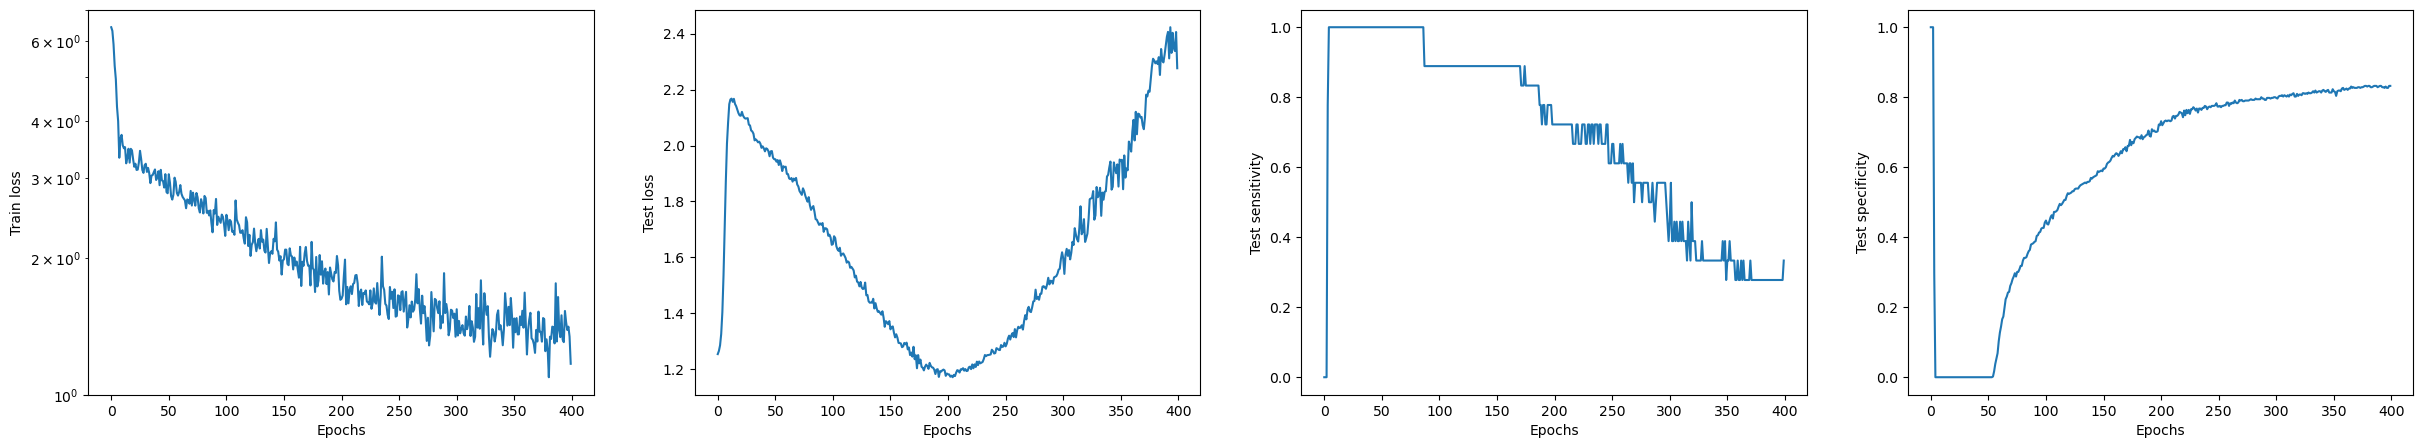

In [38]:
if train == True:
    # torch._dynamo.config.suppress_errors = True

    # Count number of positive and negative samples
    print('Number of positive samples: {}'.format((train_target == 1).sum()))
    print('Number of negative samples: {}'.format((train_target == 0).sum()))

    train_losses, test_losses, sensitivities, sppecificities, model, best_test_loss = train_model(
        model, criterion, optimizer, num_epochs=num_epochs)

    # Plot losses and accuracies separately
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Train loss')
    ax[0].set_yscale('log')
    ax[1].plot(test_losses)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Test loss')
    ax[2].plot(sensitivities)
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Test sensitivity')
    ax[3].plot(sppecificities)
    ax[3].set_xlabel('Epochs')
    ax[3].set_ylabel('Test specificity')
    
    plt.savefig('outputs/MLP-{:04}-{:02.4f}.png'.format(num_epochs, test_losses[-1]*100))
    plt.show()

    torch.save(model.state_dict(), 'pths/MLP-epoch-{}-acc-{:.4f}.pth'.format(num_epochs, best_test_loss*100))

In [39]:
def test_model(model, features, target):
    # Test in all data
    model.eval()
    outputs = model(features)
    outputs = outputs > 0.5

    # Reshape
    outputs = outputs.view(-1)
    target = target.view(-1)
    success = torch.sum(outputs == target).item()
    print('Success: {}/{}'.format(success, len(target)))

    acc = success / len(target)
    print('Accuracy: {:.2f}'.format(acc))

    # Confusion matrix
    TP = torch.sum((outputs == 1) & (target == 1)).item()
    TN = torch.sum((outputs == 0) & (target == 0)).item()
    FP = torch.sum((outputs == 1) & (target == 0)).item()
    FN = torch.sum((outputs == 0) & (target == 1)).item()

    print('TP: {}, TN: {}, FP: {}, FN: {}'.format(TP, TN, FP, FN))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    print('Sensitivity: {:.2f}, Specificity: {:.2f}'.format(sensitivity, specificity))

In [40]:
# Load model
# model.load_state_dict(torch.load('pths/MLP-500-9.5580e-01.pth'))

print('In test set:')
test_model(model, test_features, test_target)

print('\nIn all data:')
test_model(model, torch.Tensor(features).to(device), torch.Tensor(target).to(device))

In test set:
Success: 443/543
Accuracy: 0.82
TP: 6, TN: 437, FP: 88, FN: 12
Sensitivity: 0.33, Specificity: 0.83

In all data:
Success: 1535/1809
Accuracy: 0.85
TP: 56, TN: 1479, FP: 262, FN: 12
Sensitivity: 0.82, Specificity: 0.85
